初始化以及必要库的导入

In [1]:
# 基础库
import sys
import os
import numpy as np
import logging
from typing import List, Union, Callable, Dict, Any, Optional, Tuple
from dataclasses import dataclass, field
from abc import ABC, abstractmethod
from tqdm import tqdm
import json
from glob import glob  
import gc
import psutil
import matplotlib.pyplot as plt
# TensorFlow 相关
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, BatchNormalization,
    MultiHeadAttention, LayerNormalization,
    Add, Lambda, Activation, LeakyReLU,
    Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    TimeDistributed
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    Callback,
    ModelCheckpoint, 
    EarlyStopping, 
    ReduceLROnPlateau, 
    TensorBoard
)
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.model_selection import train_test_split  # 添加这行
from tensorflow.keras.utils import to_categorical  # 添加这行

# MediaPipe 相关
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic
# 更新导入语句
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, BatchNormalization,
    MultiHeadAttention, LayerNormalization,
    Add, Activation, Multiply, Lambda
)
import cv2
import tempfile
import traceback  # 添加traceback导入
import shutil
# 设置日志
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import load_model
# 设置混合精度
try:
    from tensorflow.keras.mixed_precision import global_policy, set_global_policy
    set_global_policy('mixed_float16')
except ImportError:
    from tensorflow.keras.mixed_precision import policy as mixed_precision
    mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4090, compute capability 8.9


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4090, compute capability 8.9


In [2]:
# 基础目录
BASE_DIR = "I:/Ece496"
DIRS = {
    'temp': f"{BASE_DIR}/temp",
    'tf_cache': f"{BASE_DIR}/tf_cache",
    'mp_cache': f"{BASE_DIR}/mp_cache",
    'checkpoints': f"{BASE_DIR}/checkpoints",
    'logs': f"{BASE_DIR}/logs",
    'data': f"{BASE_DIR}/data",
    'cuda_cache': f"{BASE_DIR}/cuda_cache",    
    'numpy_cache': f"{BASE_DIR}/numpy_cache",
    'opencv_cache': f"{BASE_DIR}/opencv_cache",
    'mediapipe_cache': f"{BASE_DIR}/mediapipe_cache"
}

# 创建所有必要的目录
for dir_path in DIRS.values():
    os.makedirs(dir_path, exist_ok=True)

# 扩展环境变量设置
os.environ.update({
    'TEMP': DIRS['temp'],
    'TMP': DIRS['temp'],
    'TMPDIR': DIRS['temp'],
    'KERAS_HOME': DIRS['tf_cache'],
    'MEDIAPIPE_CACHE_DIR': DIRS['mp_cache'],
    'CUDA_CACHE_PATH': DIRS['cuda_cache'],      
    'TF_CPP_MIN_LOG_LEVEL': '2',               
    'NUMEXPR_MAX_THREADS': '8',                
    'NPY_CACHE_DIR': DIRS['numpy_cache'],      
    'PYTHONUNBUFFERED': '1',
    'OPENCV_IO_ENABLE_OPENEXR': '0',           
    'OPENCV_CACHE_DIR': DIRS['opencv_cache'],  
    'OPENCV_IO_MAX_IMAGE_PIXELS': '0',         
    'OPENCV_VIDEOIO_DEBUG': '0',
    'XLA_PYTHON_CLIENT_MEM_FRACTION': '0.75',  # 控制XLA内存使用
    'TF_FORCE_GPU_ALLOW_GROWTH': 'true',       # 控制GPU内存增长
    'TF_GPU_ALLOCATOR': 'cuda_malloc_async'    # 使用异步内存分配器
})

# 设置临时文件目录
tempfile.tempdir = DIRS['temp']

# 设置NumPy配置
np.set_printoptions(precision=4)

# 设置OpenCV配置
cv2.setNumThreads(4)  # 限制OpenCV线程数
cv2.ocl.setUseOpenCL(False)  # 禁用OpenCL

# 设置MediaPipe配置
# 创建自定义的DrawingSpec而不是修改默认值
mp_drawing_styles = {
    'landmark_drawing_spec': mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2),
    'connection_drawing_spec': mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
}

# 设置TensorFlow内存增长
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except RuntimeError as e:
        print(f"无法设置内存增长: {e}")

# 7. 定义清理函数
def cleanup_all():
    """清理所有缓存目录"""
    try:
        for dir_name, dir_path in DIRS.items():
            if os.path.exists(dir_path):
                shutil.rmtree(dir_path)
                os.makedirs(dir_path)
                print(f"Cleaned {dir_name} directory")
        gc.collect()
    except Exception as e:
        print(f"Error during cleanup: {str(e)}")

# 8. 在代码开始和结束时调用清理
cleanup_all()

Cleaned temp directory
Cleaned tf_cache directory
Cleaned mp_cache directory
Cleaned checkpoints directory
Cleaned logs directory
Cleaned data directory
Cleaned cuda_cache directory
Cleaned numpy_cache directory
Cleaned opencv_cache directory
Cleaned mediapipe_cache directory


In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results
# 定义需要显示的特定面部关键点编号
selected_indices = [
    419, 290, 303, 242, 56, 155, 221, 226, 387, 362, 385, 310, 295, 340, 0, 37, 39, 40, 178, 146, 90, 72, 
    448, 380, 274, 398, 87, 98, 64, 324, 222, 1, 13, 22, 159, 145, 157, 89, 
    312, 462, 259, 63, 66, 112, 461, 463, 348, 62, 308, 119, 269, 78, 16, 65, 144, 163, 
    384, 229, 84, 321, 325, 466, 403, 182, 232, 219, 141, 249, 196, 320, 95, 
    304, 77, 272, 224, 239, 268, 316, 405, 86, 186, 
    63, 296, 334, 53, 195, 66, 107, 52, 65
]

# 定义数据类来存储每个关键点的坐标
@dataclass
class Landmark:
    x: float
    y: float
    z: float

# 定义 CustomResults 数据类
@dataclass
class CustomResults:
    face_landmarks: Optional[landmark_pb2.NormalizedLandmarkList] = None
    pose_landmarks: Optional[landmark_pb2.NormalizedLandmarkList] = None
    left_hand_landmarks: Optional[landmark_pb2.NormalizedLandmarkList] = None
    right_hand_landmarks: Optional[landmark_pb2.NormalizedLandmarkList] = None

# 提取并过滤面部关键点并生成 NormalizedLandmarkList
def create_filtered_face_landmarks(landmarks, indices):
    if not landmarks:
        return None
    filtered_landmarks = [landmarks[idx] for idx in indices]
    return landmark_pb2.NormalizedLandmarkList(landmark=filtered_landmarks)
# 使用标准的 MediaPipe 绘图方式来绘制关键点（无连接线）
def draw_landmarks(image, custom_results):
    h, w, _ = image.shape
    
    # 绘制面部关键点（不包含连接线）
    if custom_results.face_landmarks:
        for idx, landmark in zip(selected_indices, custom_results.face_landmarks.landmark):
            x, y = int(landmark.x * w), int(landmark.y * h)
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)  
            cv2.putText(image, str(idx), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1, cv2.LINE_AA)

    # 绘制姿势关键点
    if custom_results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image, custom_results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(88, 22, 88), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(66, 22, 66), thickness=2, circle_radius=2)
        )

    # 绘制左手关键点
    if custom_results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, custom_results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(100, 22, 200), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(100, 22, 200), thickness=2, circle_radius=2)
        )

    # 绘制右手关键点
    if custom_results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, custom_results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 90, 0), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(0, 90, 0), thickness=2, circle_radius=2)
        )

def calculate_velocity_acceleration(data):
    """
    计算每个帧的速度和加速度。
    
    参数：
    - data: 形状为 (num_samples, sequence_length, num_keypoints) 的 3D 数组

    返回：
    - 带有速度和加速度特征的新数据，形状为 (num_samples, sequence_length, num_keypoints * 3)
    """
    # 计算速度
    velocity = np.diff(data, axis=1)  # 对每个时间步进行差分，得到速度
    velocity = np.concatenate([velocity[:, :1, :], velocity], axis=1)  # 保持与原始帧数量一致
    
    # 计算加速度
    acceleration = np.diff(velocity, axis=1)  # 对速度再进行差分，得到加速度
    acceleration = np.concatenate([acceleration[:, :1, :], acceleration], axis=1)  # 保持与原始帧数量一致
    
    return velocity, acceleration
def calculate_relative_change(features):
    """
    计算每一帧相对于前一帧的相对变化量。
    
    参数：
    - features: 形状为 (num_samples, sequence_length, num_keypoints) 的 3D 数组

    返回：
    - 相对变化的特征
    """
    # 对每一帧计算相对变化
    relative_change = np.diff(features, axis=1)  # 计算相邻帧的差异
    relative_change = np.concatenate([relative_change[:, :1, :], relative_change], axis=1)  # 保持形状一致

    return relative_change

def extract_keypoints(custom_results):
    # 提取位置关键点 (face, pose, left_hand, right_hand)
    face = np.array([[lm.x, lm.y, lm.z] for lm in custom_results.face_landmarks.landmark]).flatten() \
        if custom_results.face_landmarks else np.zeros(90 * 3)
    pose = np.array([[lm.x, lm.y, lm.z, lm.visibility] for lm in custom_results.pose_landmarks.landmark]).flatten() \
        if custom_results.pose_landmarks else np.zeros(33 * 4)
    lh = np.array([[lm.x, lm.y, lm.z] for lm in custom_results.left_hand_landmarks.landmark]).flatten() \
        if custom_results.left_hand_landmarks else np.zeros(21 * 3)
    rh = np.array([[lm.x, lm.y, lm.z] for lm in custom_results.right_hand_landmarks.landmark]).flatten() \
        if custom_results.right_hand_landmarks else np.zeros(21 * 3)

    # 位置数据合并
    position_features = np.concatenate([face, pose, lh, rh])

    # 中心化位置特征，以第 85 个关键点（例如身体中心点）为中心
    def centralize_keypoints(keypoints, center_idx=85):
        center_x = keypoints[center_idx * 3]
        center_y = keypoints[center_idx * 3 + 1]
        center_z = keypoints[center_idx * 3 + 2]
        
        keypoints[::3] -= center_x  # X 坐标中心化
        keypoints[1::3] -= center_y  # Y 坐标中心化
        keypoints[2::3] -= center_z  # Z 坐标中心化
        return keypoints

    position_features_centered = centralize_keypoints(position_features)

    # 计算速度和加速度（不进行归一化）
    velocity, acceleration = calculate_velocity_acceleration(position_features_centered.reshape(1, -1, 3))

    # 计算相对变化
    relative_velocity = calculate_relative_change(velocity)
    relative_acceleration = calculate_relative_change(acceleration)

    # 拼接位置、速度和加速度特征
    all_features = np.concatenate([
        position_features_centered,
        relative_velocity.flatten(),
        relative_acceleration.flatten()
    ])

    return all_features
# 在 extract_keypoints 函数之后添加

def time_resample(sequence, factor):
    """时间重采样"""
    target_length = int(len(sequence) * factor)
    # 使用线性插值进行重采样
    indices = np.linspace(0, len(sequence)-1, target_length)
    indices = np.round(indices).astype(int)
    return sequence[indices]

def spatial_transform(sequence):
    """空间变换"""
    # 随机旋转角度 (-15, 15)
    angle = random.uniform(-15, 15)
    # 随机缩放因子 (0.9, 1.1)
    scale = random.uniform(0.9, 1.1)
    
    transformed = sequence.copy()
    # 应用变换
    # 注意：需要保持关键点之间的相对关系
    return transformed

def random_mask(sequence):
    """随机掩码"""
    masked = sequence.copy()
    # 随机选择时间窗口
    t_start = random.randint(0, len(sequence)-3)
    t_len = random.randint(2, 4)
    # 随机选择特征点
    feature_indices = random.sample(range(sequence.shape[1]), 
                                  k=random.randint(2, 6))
    # 应用掩码
    masked[t_start:t_start+t_len, feature_indices] = 0
    return masked

In [4]:
# 定义词语和标签映射
# 定义词语和标签映射
words = [
    'hello',
    'see u later',
    'I or me',
    'father',
    'mother',
    'Yes',
    'No',
    'Help',
    'Please',
    'Thank You',
    'Want',
    'What',
    'Dog',
    'Cat',
    'Again or Repeat',
    'Eat',
    'Milk',
    'More',
    'Go To',
    'Bathroom',
    'Fine',
    'Like',
    'Learn',
    'Sign',
    'Finish or Done'
]

label_map = {label: num for num, label in enumerate(words)}
DATA_PATH = 'I:/Ece496/custom_data'
sequence_length = int(30 * 3.5)  # 每个视频的帧数




训练相关所需的数据加载以及预处理

In [9]:
# 初始化路径
DATA_PATH = "I:\\Ece496\\custom_data"
PROCESSED_VIDEOS_PATH = os.path.join(DATA_PATH, "processed_videos_velocity.txt")
SEQUENCE_COUNTER_PATH = os.path.join(DATA_PATH, "sequence_counter_velocity.json")

# 确保目录存在
os.makedirs(DATA_PATH, exist_ok=True)

# 要重置计数的单词列表
words_to_reset = []  # 在这里添加需要重置的单词

# 加载之前保存的关键点数据
if os.path.exists(os.path.join(DATA_PATH, "X_velocity.npy")) and os.path.exists(os.path.join(DATA_PATH, "y_velocity.npy")):
    print("Loading existing data...")
    X = np.load(os.path.join(DATA_PATH, "X_velocity.npy"))
    y = np.load(os.path.join(DATA_PATH, "y_velocity.npy"))
    sequences = list(X)  # 转为列表，以便后续可以追加新数据
    labels = list(y)  # 转为列表
    print(f"Loaded {len(sequences)} existing sequences")
else:
    print("No existing data found, starting fresh...")
    sequences = []
    labels = []

# 加载已处理的视频路径
if os.path.exists(PROCESSED_VIDEOS_PATH):
    print("Loading processed videos list...")
    with open(PROCESSED_VIDEOS_PATH, 'r') as f:
        processed_videos = set(line.strip() for line in f)
    print(f"Found {len(processed_videos)} processed videos")
else:
    print("No processed videos list found, starting fresh...")
    processed_videos = set()

# 加载和验证 sequence_counter 状态
if os.path.exists(SEQUENCE_COUNTER_PATH):
    print("Loading sequence counter...")
    with open(SEQUENCE_COUNTER_PATH, 'r') as f:
        sequence_counter = json.load(f)
    
    # 重置指定单词的计数
    for word in words_to_reset:
        if word in sequence_counter:
            print(f"Resetting counter for word: {word}")
            sequence_counter[word] = 0
    
    # 确保所有单词都在计数器中
    for word in words:
        if word not in sequence_counter:
            print(f"Adding missing word to counter: {word}")
            sequence_counter[word] = 0
else:
    print("Initializing new sequence counter...")
    sequence_counter = {word: 0 for word in words}

# 打印初始计数器状态
print("\nInitial sequence counter state:")
for word in words:
    print(f"{word}: {sequence_counter[word]}")

# 打印处理开始信息
print("\nStarting video processing...")
print(f"Total words to process: {len(words)}")

# 处理每个单词的视频
for word in words:
    word_path = os.path.join(DATA_PATH, word)
    if not os.path.exists(word_path):
        print(f"Warning: Directory not found for word '{word}': {word_path}")
        continue
        
    video_files = glob(os.path.join(word_path, f"{word}_*.mp4"))
    print(f"\nProcessing word '{word}': found {len(video_files)} videos")
    
    for video_file in video_files:
        if video_file in processed_videos:
            print(f"Skipping already processed video: {video_file}")
            continue

        # 每次处理一个新的文件，就增加该 word 的计数
        sequence_counter[word] += 1
        sequence = sequence_counter[word]

        print(f"Processing video: {video_file}, sequence: {sequence}, label: {label_map[word]}")

        cap = cv2.VideoCapture(video_file)
        window = []

        try:
            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                frame_num = 0
                while frame_num < sequence_length:
                    ret, frame = cap.read()
                    if not ret:
                        print(f"Failed to read frame {frame_num} from {video_file}")
                        # 使用零向量填充剩余帧
                        remaining_frames = sequence_length - len(window)
                        if remaining_frames > 0:
                            zero_keypoints = np.zeros(1584)  # 特征维度为1584
                            for _ in range(remaining_frames):
                                window.append(zero_keypoints)
                        break
                    
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    results = holistic.process(frame_rgb)

                    if results.face_landmarks is None:
                        print(f"No face landmarks detected in frame {frame_num}")
                        # 对于检测不到面部特征的帧，使用零向量
                        zero_keypoints = np.zeros(1584)
                        window.append(zero_keypoints)
                        frame_num += 1
                        continue

                    custom_results = CustomResults(
                        face_landmarks=create_filtered_face_landmarks(results.face_landmarks.landmark, selected_indices) if results.face_landmarks else None,
                        pose_landmarks=results.pose_landmarks,
                        left_hand_landmarks=results.left_hand_landmarks,
                        right_hand_landmarks=results.right_hand_landmarks
                    )
                    
                    keypoints = extract_keypoints(custom_results)
                    window.append(keypoints)
                    frame_num += 1

        except Exception as e:
            print(f"Error processing video {video_file}: {str(e)}")
            # 如果发生异常，检查是否需要填充
            if len(window) < sequence_length:
                remaining_frames = sequence_length - len(window)
                zero_keypoints = np.zeros(1584)
                for _ in range(remaining_frames):
                    window.append(zero_keypoints)
        finally:
            cap.release()

        # 现在我们总是会有一个完整的序列
        sequences.append(window)
        labels.append(label_map[word])
        processed_videos.add(video_file)
        print(f"Successfully added sequence for word '{word}', sequence {sequence}, label: {label_map[word]}")
        if len(window) > sequence_length:
            print(f"Warning: Sequence was truncated from {len(window)} frames to {sequence_length}")
        elif len(window) < sequence_length:
            print(f"Warning: Sequence was padded from {len(window)} frames to {sequence_length}")

        # 每次成功处理一个视频后，保存 sequence_counter 状态
        try:
            with open(SEQUENCE_COUNTER_PATH, 'w') as f:
                json.dump(sequence_counter, f)
            print("Updated sequence counter saved")
        except Exception as e:
            print(f"Error saving sequence counter: {str(e)}")

# 保存处理过的视频路径到 txt 文件
try:
    with open(PROCESSED_VIDEOS_PATH, 'w') as f:
        for video_path in processed_videos:
            f.write(f"{video_path}\n")
    print("\nSaved processed videos list")
except Exception as e:
    print(f"Error saving processed videos list: {str(e)}")

# 转换 sequences 和 labels 为 NumPy 数组并保存
if sequences and labels:
    try:
        X = np.array(sequences)
        y = np.array(labels)
        np.save(os.path.join(DATA_PATH, "X_velocity.npy"), X)
        np.save(os.path.join(DATA_PATH, "y_velocity.npy"), y)
        print("\nSuccessfully saved processed data:")
        print(f"Total sequences: {len(sequences)}")
        print(f"X shape: {X.shape}")
        print(f"y shape: {y.shape}")
    except Exception as e:
        print(f"Error saving processed data: {str(e)}")
else:
    print("\nNo sequences to save")

Loading existing data...
Loaded 1657 existing sequences
Loading processed videos list...
Found 1657 processed videos
Loading sequence counter...

Initial sequence counter state:
hello: 105
see u later: 103
I or me: 103
father: 100
mother: 106
Yes: 60
No: 60
Help: 60
Please: 61
Thank You: 60
Want: 60
What: 48
Dog: 60
Cat: 58
Again or Repeat: 60
Eat: 20
Milk: 60
More: 60
Go To: 60
Bathroom: 60
Fine: 59
Like: 60
Learn: 60
Sign: 60
Finish or Done: 60

Starting video processing...
Total words to process: 25

Processing word 'hello': found 105 videos
Skipping already processed video: I:\Ece496\custom_data\hello\hello_1_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_2_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_3_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_4_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_5_Bill.mp4
Skipping already processed video: I:\Ece496\custom_dat

In [10]:
# 假设 label_map 是一个字典，形如 {"hello": 0, "goodbye": 1, ...}
# 创建反向映射：从 label 到单词
reverse_label_map = {v: k for k, v in label_map.items()}

# 打印每个 label 对应的单词
print("Label 对应的单词如下:")
for label, word in reverse_label_map.items():
    print(f"Label {label}: {word}")


Label 对应的单词如下:
Label 0: hello
Label 1: see u later
Label 2: I or me
Label 3: father
Label 4: mother
Label 5: Yes
Label 6: No
Label 7: Help
Label 8: Please
Label 9: Thank You
Label 10: Want
Label 11: What
Label 12: Dog
Label 13: Cat
Label 14: Again or Repeat
Label 15: Eat
Label 16: Milk
Label 17: More
Label 18: Go To
Label 19: Bathroom
Label 20: Fine
Label 21: Like
Label 22: Learn
Label 23: Sign
Label 24: Finish or Done


In [11]:
y = to_categorical(labels, num_classes=len(words)).astype(int)
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [12]:
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1657, 105, 1584)
y shape: (1657, 25)


In [10]:

y = to_categorical(labels, num_classes=len(words)).astype(int)

# 先分割出 20% 的测试集
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 然后在剩下的 80% 中分割出 10% 的验证集
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, random_state=42  # 0.125 * 0.8 = 0.1
)

# 确认分割后的数据形状
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)
print("保存测试数据到硬盘...")
test_data_dir = "I:/Ece496/augmented_data"
os.makedirs(test_data_dir, exist_ok=True)

np.save(os.path.join(test_data_dir, "X_test.npy"), X_test)
np.save(os.path.join(test_data_dir, "y_test.npy"), y_test)


X_train shape: (1158, 105, 1584)
X_val shape: (166, 105, 1584)
X_test shape: (332, 105, 1584)
y_train shape: (1158, 25)
y_val shape: (166, 25)
y_test shape: (332, 25)
保存测试数据到硬盘...


数据增强

In [11]:
# 设置日志
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class StaticAugConfig:
    """静态增强配置"""
    enabled: bool = True
    save_dir: str = "I:/Ece496/augmented_data"
    batch_size: int = 4  # 减小批次大小
    sub_batch_size: int = 2  # 子批次大小，用于更细粒度的处理
    max_memory_percent: float = 70.0  # 最大内存使用百分比
    augmentation_types: List[str] = None
    
    def __post_init__(self):
        if self.augmentation_types is None:
            self.augmentation_types = [
                "spatial_transform",
                "random_mask",
                "time_resample",
                "cutmix",           # 新增
                "affine_transform", # 新增
                "gaussian_noise"    # 新增
            ]

class MemoryMonitor:
    """内存监控器"""
    @staticmethod
    def get_memory_usage():
        process = psutil.Process(os.getpid())
        return process.memory_percent()

    @staticmethod
    def check_memory(config: StaticAugConfig):
        memory_usage = MemoryMonitor.get_memory_usage()
        if memory_usage > config.max_memory_percent:
            gc.collect()
            return False
        return True

class StaticAugmentation:
    def __init__(self, config: StaticAugConfig):
        self.config = config
        self.aug_data_path = os.path.join(self.config.save_dir, "augmented")
        self.metadata_path = os.path.join(self.config.save_dir, "metadata.json")
        os.makedirs(self.aug_data_path, exist_ok=True)
        self.memory_monitor = MemoryMonitor()

    def spatial_transform(self, sequence: np.ndarray, scale_range=(0.9, 1.1)) -> np.ndarray:
        """空间变换增强"""
        try:
            seq = sequence.copy().astype(np.float32)  # 确保使用float32
            scale = np.random.uniform(*scale_range)
            for i in range(0, seq.shape[1], 3):
                seq[:, i:i+3] *= scale
            return seq
        except Exception as e:
            logger.error(f"空间变换增强失败: {str(e)}")
            return sequence.astype(np.float32)

    def random_mask(self, sequence: np.ndarray, mask_size_range=(2, 4)) -> np.ndarray:
        """随机掩码增强"""
        try:
            seq = sequence.copy().astype(np.float32)
            window_size = np.random.randint(*mask_size_range)
            start_idx = np.random.randint(0, seq.shape[0] - window_size)
            num_features = sequence.shape[1] // 3
            mask_features = np.random.choice(
                range(num_features), 
                size=np.random.randint(2, 4), 
                replace=False
            )
            
            for feature_idx in mask_features:
                idx = feature_idx * 3
                seq[start_idx:start_idx+window_size, idx:idx+3] = 0
            return seq
        except Exception as e:
            logger.error(f"随机掩码增强失败: {str(e)}")
            return sequence.astype(np.float32)

    def time_resample(self, sequence: np.ndarray, factor_range=(0.8, 1.2)) -> np.ndarray:
        """时间重采样增强"""
        try:
            sequence = sequence.astype(np.float32)
            factor = np.random.uniform(*factor_range)
            target_length = int(len(sequence) * factor)
            indices = np.linspace(0, len(sequence)-1, target_length)
            indices = np.round(indices).astype(np.int32)
            resampled = sequence[indices]
            
            if len(resampled) != len(sequence):
                indices = np.linspace(0, len(resampled)-1, len(sequence))
                indices = np.round(indices).astype(np.int32)
                resampled = resampled[indices]
            
            return resampled
        except Exception as e:
            logger.error(f"时间重采样增强失败: {str(e)}")
            return sequence

    def cutmix(self, sequence: np.ndarray, other_sequences: np.ndarray = None) -> np.ndarray:
        """CutMix增强
        将两个序列的部分片段混合
        """
        try:
            seq = sequence.copy().astype(np.float32)
            if other_sequences is None or len(other_sequences) == 0:
                return seq
                
            # 随机选择另一个序列
            other_seq = other_sequences[np.random.randint(len(other_sequences))]
            
            # 随机选择混合区域
            t_start = np.random.randint(0, len(sequence) - 10)
            t_length = np.random.randint(5, 20)
            t_end = min(t_start + t_length, len(sequence))
            
            # 随机选择要混合的特征
            num_features = sequence.shape[1] // 3
            mix_features = np.random.choice(
                range(num_features), 
                size=np.random.randint(num_features//4, num_features//2),
                replace=False
            )
            
            # 混合序列
            for feature_idx in mix_features:
                idx = feature_idx * 3
                seq[t_start:t_end, idx:idx+3] = other_seq[t_start:t_end, idx:idx+3]
            
            return seq
            
        except Exception as e:
            logger.error(f"CutMix增强失败: {str(e)}")
            return sequence.astype(np.float32)

    def affine_transform(self, sequence: np.ndarray) -> np.ndarray:
        """仿射变换增强
        包括旋转、缩放、剪切等
        """
        try:
            seq = sequence.copy().astype(np.float32)
            
            # 生成仿射变换矩阵
            angle = np.random.uniform(-15, 15)  # 旋转角度
            scale = np.random.uniform(0.8, 1.2)  # 缩放因子
            shear = np.random.uniform(-0.1, 0.1)  # 剪切因子
            
            # 构建仿射矩阵
            rad = np.deg2rad(angle)
            affine_matrix = np.array([
                [scale * np.cos(rad), -np.sin(rad) + shear, 0],
                [np.sin(rad) + shear, scale * np.cos(rad), 0],
                [0, 0, 1]
            ])
            
            # 应用变换到每个关键点
            for i in range(0, seq.shape[1], 3):
                points = seq[:, i:i+3]  # 获取xyz坐标
                # 添加齐次坐标
                homogeneous = np.ones((len(points), 3))
                homogeneous[:, :2] = points[:, :2]  # 只变换xy平面
                
                # 应用变换
                transformed = np.dot(homogeneous, affine_matrix.T)
                seq[:, i:i+2] = transformed[:, :2]  # 更新xy坐标
            
            return seq
            
        except Exception as e:
            logger.error(f"仿射变换增强失败: {str(e)}")
            return sequence.astype(np.float32)

    def gaussian_noise(self, sequence: np.ndarray, mean=0, std=0.01) -> np.ndarray:
        """添加高斯噪声"""
        try:
            seq = sequence.copy().astype(np.float32)
            noise = np.random.normal(mean, std, seq.shape)
            seq += noise
            return seq
            
        except Exception as e:
            logger.error(f"高斯噪声增强失败: {str(e)}")
            return sequence.astype(np.float32)

    def process_sub_batch(self, sequences, labels):
        """处理子批次"""
        aug_sequences = []
        aug_labels = []
        
        # 保存原始数据
        aug_sequences.extend(sequences)
        aug_labels.extend(labels)
        
        # 应用增强
        for aug_type in self.config.augmentation_types:
            if not MemoryMonitor.check_memory(self.config):
                logger.warning(f"内存使用过高，跳过{aug_type}增强")
                continue
                
            aug_func = getattr(self, aug_type)
            for seq, label in zip(sequences, labels):
                if aug_type == 'cutmix':
                    # 为cutmix提供其他序列
                    other_seqs = [s for s in sequences if not np.array_equal(s, seq)]
                    aug_seq = aug_func(seq, other_seqs)
                else:
                    aug_seq = aug_func(seq)
                    
                aug_sequences.append(aug_seq)
                aug_labels.append(label)
                
        return np.array(aug_sequences, dtype=np.float32), np.array(aug_labels, dtype=np.float32)
    def process_batch(self, sequences, labels, batch_idx):
        """处理批次"""
        try:
            # 分子批次处理
            sub_batches_sequences = []
            sub_batches_labels = []
            
            for i in range(0, len(sequences), self.config.sub_batch_size):
                end_idx = min(i + self.config.sub_batch_size, len(sequences))
                sub_sequences = sequences[i:end_idx]
                sub_labels = labels[i:end_idx]
                
                aug_sequences, aug_labels = self.process_sub_batch(sub_sequences, sub_labels)
                sub_batches_sequences.append(aug_sequences)
                sub_batches_labels.append(aug_labels)
                
                gc.collect()
            
            # 合并子批次
            aug_sequences = np.concatenate(sub_batches_sequences, axis=0)
            aug_labels = np.concatenate(sub_batches_labels, axis=0)
            
            # 保存到硬盘
            batch_path = os.path.join(self.aug_data_path, f"batch_{batch_idx}")
            np.save(f"{batch_path}_sequences.npy", aug_sequences)
            np.save(f"{batch_path}_labels.npy", aug_labels)
            
            # 清理内存
            del aug_sequences, aug_labels, sub_batches_sequences, sub_batches_labels
            gc.collect()
            
        except Exception as e:
            logger.error(f"批次 {batch_idx} 处理失败: {str(e)}")
            raise

    def _load_and_merge_batches(self, num_batches):
        """逐批加载并合并数据"""
        try:
            # 首先加载第一个批次
            base_sequences = np.load(os.path.join(self.aug_data_path, "batch_0_sequences.npy"))
            base_labels = np.load(os.path.join(self.aug_data_path, "batch_0_labels.npy"))
            
            # 逐个加载并合并其余批次
            for i in tqdm(range(1, num_batches), desc="合并批次"):
                if not MemoryMonitor.check_memory(self.config):
                    logger.warning("内存使用过高，等待GC")
                    continue
                    
                batch_path = os.path.join(self.aug_data_path, f"batch_{i}")
                next_sequences = np.load(f"{batch_path}_sequences.npy")
                next_labels = np.load(f"{batch_path}_labels.npy")
                
                base_sequences = np.concatenate([base_sequences, next_sequences], axis=0)
                base_labels = np.concatenate([base_labels, next_labels], axis=0)
                
                del next_sequences, next_labels
                gc.collect()
            
            return base_sequences, base_labels
            
        except Exception as e:
            logger.error(f"批次加载和合并失败: {str(e)}")
            raise

    def augment_dataset(self, sequences: np.ndarray, labels: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """处理整个数据集"""
        try:
            # 确保输入数据类型为float32
            sequences = sequences.astype(np.float32)
            labels = labels.astype(np.float32)
            
            # 清空增强数据目录
            if os.path.exists(self.aug_data_path):
                for file in os.listdir(self.aug_data_path):
                    os.remove(os.path.join(self.aug_data_path, file))
            
            # 分批处理数据
            num_samples = len(sequences)
            num_batches = (num_samples + self.config.batch_size - 1) // self.config.batch_size
            
            metadata = {
                "num_batches": num_batches,
                "original_shape": sequences.shape,
                "augmentation_types": self.config.augmentation_types
            }
            
            with open(self.metadata_path, 'w') as f:
                json.dump(metadata, f)
            
            # 处理每个批次
            for i in tqdm(range(num_batches), desc="处理批次"):
                if not MemoryMonitor.check_memory(self.config):
                    logger.warning("内存使用过高，等待GC")
                    continue
                    
                start_idx = i * self.config.batch_size
                end_idx = min((i + 1) * self.config.batch_size, num_samples)
                
                batch_sequences = sequences[start_idx:end_idx]
                batch_labels = labels[start_idx:end_idx]
                
                self.process_batch(batch_sequences, batch_labels, i)
                gc.collect()
            
            # 合并所有批次
            return self._load_and_merge_batches(num_batches)
                
        except Exception as e:
            logger.error(f"数据集增强失败: {str(e)}")
            return sequences, labels

def apply_augmentation(X_train, y_train, config: Optional[StaticAugConfig] = None):
    """应用数据增强的便捷函数"""
    if config is None:
        config = StaticAugConfig()
    
    augmentor = StaticAugmentation(config)
    return augmentor.augment_dataset(X_train, y_train)

In [12]:
# 创建配置
aug_config = StaticAugConfig(
    batch_size=8,              # 每批处理8个样本
    sub_batch_size=4,          # 子批次4个样本
    max_memory_percent=70.0,   # 内存使用上限70%
    save_dir="I:/Ece496/augmented_data", # 增强数据保存目录
    augmentation_types=[
        "spatial_transform",    # 原有的空间变换
        "random_mask",         # 原有的随机掩码
        "time_resample",       # 原有的时间重采样
        "cutmix",              # 新增的CutMix
        "affine_transform",    # 新增的仿射变换
        "gaussian_noise"       # 新增的高斯噪声
    ]
)

# 应用数据增强
print("开始数据增强...")
X_train_aug, y_train_aug = apply_augmentation(X_train, y_train, aug_config)
print(f"增强后的训练数据大小: {X_train_aug.shape}")
print("保存增强后的数据...")
np.save('I:/Ece496/augmented_data/X_train_aug.npy', X_train_aug)
np.save('I:/Ece496/augmented_data/y_train_aug.npy', y_train_aug)
print("数据保存完成！")

开始数据增强...


处理批次:   4%|▍         | 6/145 [00:05<01:57,  1.18it/s]


KeyboardInterrupt: 

模型构建

In [5]:
class ModelBuilder:
    """模型构建器"""
    
    def create_attention_residual_model(self, input_shape, num_classes):
        """创建实时的带有多头注意力机制的残差LSTM模型"""
        try:
            inputs = Input(shape=input_shape)
            
            # 1. 初始特征处理 - 使用单向LSTM保持实时性
            x = LSTM(128, return_sequences=True, 
                    kernel_initializer='he_normal',
                    recurrent_initializer='orthogonal',
                    use_bias=True,  # 启用 bias
                    activation='tanh',  # 使用 tanh 激活函数
                    recurrent_activation='sigmoid',  # 使用 sigmoid 门激活函数
                    implementation=2  # 使用更快的实现
                    )(inputs)
            x = BatchNormalization()(x)
            
            # 2. 因果多头注意力模块（只关注当前及之前的时间步）
            attention_output = MultiHeadAttention(
                num_heads=8,
                key_dim=16,
                dropout=0.1,
                use_bias=False
            )(x, x, x, use_causal_mask=True)
            
            # 3. 残差连接和层标准化
            x = Add()([x, attention_output])
            x = LayerNormalization(epsilon=1e-6)(x)
            
            # 4. 前馈神经网络
            ffn = Dense(256, activation='gelu')(x)
            ffn = Dropout(0.1)(ffn)
            ffn = Dense(128)(ffn)
            
            # 5. 第二个残差连接
            x = Add()([x, ffn])
            x = LayerNormalization(epsilon=1e-6)(x)
            
            # 6. 第二个LSTM层 - 保持单向
            x = LSTM(64, return_sequences=True,
                    kernel_initializer='he_normal',
                    recurrent_initializer='orthogonal',
                    use_bias=True,  # 启用 bias
                    activation='tanh',  # 使用 tanh 激活函数
                    recurrent_activation='sigmoid',  # 使用 sigmoid 门激活函数
                    implementation=2  # 使用更快的实现
                    )(x)
            x = BatchNormalization()(x)
            
            # 7. 实时注意力池化（只关注当前时间步）
            attention = Dense(128, use_bias=False)(x)
            attention = Activation('tanh')(attention)
            attention = Dense(1, use_bias=False)(attention)
            attention_weights = Activation('softmax', name='attention_weights')(attention)
            x = Multiply()([x, attention_weights])
            
            # 8. 特征聚合 - 使用最后一个时间步的输出
            x = Lambda(lambda x: x[:, -1, :])(x)
            x = Dense(128, activation='gelu')(x)
            x = Dropout(0.2)(x)
            
            # 9. 输出层
            outputs = Dense(num_classes, activation='softmax',
                          kernel_initializer='he_normal')(x)
            
            # 10. 构建模型
            model = Model(inputs=inputs, outputs=outputs)
            
            # 11. 编译模型
            optimizer = Adam(learning_rate=0.001)
            optimizer = mixed_precision.LossScaleOptimizer(optimizer)
            
            model.compile(
                optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            
            logger.info("注意力残差模型创建成功")
            return model
            
        except Exception as e:
            logger.error(f"创建注意力残差模型失败: {str(e)}")
            raise
    @staticmethod
    def create_original_model(input_shape, num_classes):
        """创建增强版原始LSTM模型"""
        try:
            model = Sequential([
                # 第一个LSTM块
                LSTM(128, return_sequences=True, activation='tanh', input_shape=input_shape),
                BatchNormalization(),
                Dropout(0.2),
                
                # 第二个LSTM块
                LSTM(64, return_sequences=True, activation='tanh'),
                BatchNormalization(),
                Dropout(0.2),
                
                # 第三个LSTM块
                LSTM(32, activation='tanh'),
                BatchNormalization(),
                
                # 全连接层
                Dense(64),
                LeakyReLU(alpha=0.1),
                BatchNormalization(),
                
                Dense(32),
                LeakyReLU(alpha=0.1),
                BatchNormalization(),
                
                # 输出层
                Dense(num_classes, activation='softmax')
            ])
            
            model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            return model
        except Exception as e:
            logger.error(f"创建原始模型失败: {str(e)}")
            raise

    @staticmethod
    def create_residual_model(input_shape, num_classes):
        """创建真正的残差LSTM模型"""
        try:
            # 输入层
            inputs = Input(shape=input_shape)
            
            # 第一个LSTM残差块
            x = LSTM(128, return_sequences=True, activation='tanh')(inputs)
            x = BatchNormalization()(x)
            residual = x  # 128维
            x = LSTM(128, return_sequences=True, activation='tanh')(x)
            x = BatchNormalization()(x)
            x = Add()([x, residual])  # 维度匹配：都是128
            x = Dropout(0.2)(x)
            
            # 第二个LSTM残差块
            # 先用Dense调整维度
            residual = Dense(64)(x)  # 从128调整到64
            x = LSTM(64, return_sequences=True, activation='tanh')(x)
            x = BatchNormalization()(x)
            x = LSTM(64, return_sequences=True, activation='tanh')(x)
            x = BatchNormalization()(x)
            x = Add()([x, residual])  # 现在都是64维
            x = Dropout(0.2)(x)
            
            # 最后的LSTM层
            x = LSTM(32, activation='tanh')(x)
            x = BatchNormalization()(x)
            
            # 全连接层
            x = Dense(64)(x)
            x = LeakyReLU(alpha=0.1)(x)
            x = BatchNormalization()(x)
            
            x = Dense(32)(x)
            x = LeakyReLU(alpha=0.1)(x)
            x = BatchNormalization()(x)
            
            # 输出层
            outputs = Dense(num_classes, activation='softmax')(x)
            
            model = Model(inputs=inputs, outputs=outputs)
            model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            
            # 打印模型结构
            print("\n残差模型结构:")
            model.summary()
            
            return model
        except Exception as e:
            logger.error(f"创建残差模型失败: {str(e)}")
            raise

# def apply_augmentation(data):
#     """
#     应用数据增强
#     参数:
#         data: 输入数据 shape=(samples, timesteps, features)
#     返回:
#         增强后的数据
#     """
#     augmented = data.copy()
    
#     # 随机选择增强方法
#     if np.random.random() < 0.5:
#         # 添加随机噪声
#         noise = np.random.normal(0, 0.01, data.shape)
#         augmented += noise
    
#     if np.random.random() < 0.5:
#         # 随机时间偏移
#         shift = np.random.randint(-10, 10)
#         augmented = np.roll(augmented, shift, axis=1)
    
#     return augmented

# def augment_dataset(X, y, augment_times=1):
#     """
#     对数据集进行增强
#     参数:
#         X: 输入数据
#         y: 标签
#         augment_times: 增强次数
#     返回:
#         增强后的数据集和标签
#     """
#     X_aug = [X]
#     y_aug = [y]
    
#     for _ in range(augment_times):
#         X_augmented = apply_augmentation(data=X)
#         X_aug.append(X_augmented)
#         y_aug.append(y)
    
#     return np.concatenate(X_aug, axis=0), np.concatenate(y_aug, axis=0)

    
# def train_model(self, model, X_train, y_train, X_val, y_val, model_type: str):
#     """训练模型"""
#     # 数据增强
#     X_train_aug, y_train_aug = augment_dataset(X_train, y_train, augment_times=1)
#     print(f"增强后的训练数据大小: {X_train_aug.shape}")
    
#     # 训练模型
#     history = model.fit(
#         X_train_aug, y_train_aug,
#         validation_data=(X_val, y_val),
#         epochs=self.config['epochs'],
#         batch_size=self.config['batch_size'],
#         callbacks=self.get_callbacks(model_type),
#         verbose=1
#     )
    
#     return history

def plot_training_history(original_history, residual_history):
    """绘制两个模型的训练历史对比图"""
    plt.figure(figsize=(15, 10))
    
    # 1. 准确率对比
    plt.subplot(2, 2, 1)
    plt.plot(original_history.history['accuracy'], label='原始模型 (训练)')
    plt.plot(original_history.history['val_accuracy'], label='原始模型 (验证)')
    plt.plot(residual_history.history['accuracy'], label='残差模型 (训练)')
    plt.plot(residual_history.history['val_accuracy'], label='残差模型 (验证)')
    plt.title('模型准确率对比')
    plt.xlabel('Epoch')
    plt.ylabel('准确率')
    plt.legend()
    plt.grid(True)

    # 2. 损失值对比
    plt.subplot(2, 2, 2)
    plt.plot(original_history.history['loss'], label='原始模型 (训练)')
    plt.plot(original_history.history['val_loss'], label='原始模型 (验证)')
    plt.plot(residual_history.history['loss'], label='残差模型 (训练)')
    plt.plot(residual_history.history['val_loss'], label='残差模型 (验证)')
    plt.title('模型损失值对比')
    plt.xlabel('Epoch')
    plt.ylabel('损失值')
    plt.legend()
    plt.grid(True)

    # 3. 学习率变化
    plt.subplot(2, 2, 3)
    plt.plot(original_history.history['lr'], label='原始模型')
    plt.plot(residual_history.history['lr'], label='残差模型')
    plt.title('学习率变化')
    plt.xlabel('Epoch')
    plt.ylabel('学习率')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')

    plt.tight_layout()
    plt.show()




训练相关代码

In [14]:
class TrainingManager:
    """训练管理器"""
    def __init__(self, config: Optional[dict] = None):
        self.config = {
            'batch_size': 64,          # 增大批次大小
            'epochs': 100,             # 设置总轮数
            'validation_split': 0.2,
            'early_stopping_patience': 15,
            'reduce_lr_patience': 3,
            'model_checkpoint_path': 'I:/Ece496/checkpoints/best_model_{}.h5',
            'workers': 2,              # 添加worker配置
            'max_queue_size': 10,      # 添加队列配置
            'use_multiprocessing': False  # 添加多进程配置
        }
        if config:
            self.config.update(config)
    
    def get_callbacks(self, model_type: str):
        """获取回调函数列表"""
        return [
            EarlyStopping(
                monitor='val_loss',
                patience=self.config['early_stopping_patience'],
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.3,
                patience=self.config['reduce_lr_patience'],
                min_lr=1e-6,
                verbose=1
            ),
            ModelCheckpoint(
                self.config['model_checkpoint_path'].format(model_type),
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            )
        ]
    
    def get_training_config(self):
        """获取训练配置"""
        return {
            'epochs': self.config['epochs'],
            'workers': self.config['workers'],
            'max_queue_size': self.config['max_queue_size'],
            'use_multiprocessing': self.config['use_multiprocessing']
        }

In [11]:
class DataGenerator(Sequence):
    """数据生成器"""
    def __init__(self, X_path, y_path, batch_size=32, shuffle=True):
        self.X_mmap = np.load(X_path, mmap_mode='r')  # 内存映射模式
        self.y_mmap = np.load(y_path, mmap_mode='r')
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X_mmap))
        
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
        self.logger = logging.getLogger(__name__)
        self.logger.info(f"数据生成器初始化完成:")
        self.logger.info(f"- 总样本数: {len(self.X_mmap)}")
        self.logger.info(f"- 批次大小: {batch_size}")
        self.logger.info(f"- 每轮批次数: {len(self)}")
    
    def __len__(self):
        """计算每个epoch的批次数"""
        return int(np.ceil(len(self.X_mmap) / self.batch_size))
    
    def __getitem__(self, idx):
        """获取一个批次的数据"""
        # 计算当前批次的索引
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # 使用内存映射按需加载数据
        batch_x = self.X_mmap[batch_indexes].astype(np.float32)
        batch_y = self.y_mmap[batch_indexes]
        
        return batch_x, batch_y
    
    def on_epoch_end(self):
        """在每个epoch结束时调用"""
        if self.shuffle:
            np.random.shuffle(self.indexes)
# def load_and_preprocess_data():
#     """加载和预处理数据"""
#     logger.info("加载原始数据...")
    
#     # 修改数据加载路径
#     X = np.load('I:/Ece496/augmented_data/X_train_aug.npy')
#     y = np.load('I:/Ece496/augmented_data/y_train_aug.npy')
    
#     # 数据分割
#     from sklearn.model_selection import train_test_split
    
#     # 首先分割出测试集
#     X_temp, X_test, y_temp, y_test = train_test_split(
#         X, y, test_size=0.2, random_state=42, stratify=y.argmax(axis=1)
#     )
    
#     # 然后从剩余数据中分割出验证集
#     X_train, X_val, y_train, y_val = train_test_split(
#         X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp.argmax(axis=1)
#     )
    
#     logger.info(f"数据形状:")
#     logger.info(f"X_train: {X_train.shape}")
#     logger.info(f"X_val: {X_val.shape}")
#     logger.info(f"X_test: {X_test.shape}")
    
#     return X_train, X_val, X_test, y_train, y_val, y_test, None  # words设为None


# 设置混合精度训练
mixed_precision.set_global_policy('mixed_float16')
print("计算精度:", mixed_precision.global_policy())


def main():
    """主程序入口"""
    try:
        # 1. 加载原始数据
        logger.info("加载数据...")
        
        # 2. 创建数据生成器
        logger.info("创建数据生成器...")
        train_generator = DataGenerator(
            X_path='I:/Ece496/augmented_data/X_train_aug.npy',
            y_path='I:/Ece496/augmented_data/y_train_aug.npy',
            batch_size=64,
            shuffle=True
        )
        
        val_generator = DataGenerator(
            X_path='I:/Ece496/augmented_data/X_val.npy',
            y_path='I:/Ece496/augmented_data/y_val.npy',
            batch_size=64,
            shuffle=False
        )
        
        # 获取输入形状和类别数
        X_mmap = np.load('I:/Ece496/augmented_data/X_train_aug.npy', mmap_mode='r')
        y_mmap = np.load('I:/Ece496/augmented_data/y_train_aug.npy', mmap_mode='r')
        input_shape = X_mmap.shape[1:]
        num_classes = y_mmap.shape[1]
        
        # 3. 创建注意力残差模型
        logger.info("创建注意力残差模型...")
        model_builder = ModelBuilder()
        attention_model = model_builder.create_attention_residual_model(input_shape, num_classes)
        
        # 4. 创建训练管理器并获取回调
        # 创建训练管理器
        trainer = TrainingManager()
        
        # 使用训练管理器的配置
        training_config = trainer.get_training_config()
        
        # 训练模型
        attention_history = attention_model.fit(
            train_generator,
            validation_data=val_generator,
            callbacks=trainer.get_callbacks('attention'),
            **training_config,  # 使用训练管理器的配置
            verbose=1
        )
        
        # 6. 保存训练历史
        logger.info("保存训练历史...")
        os.makedirs('I:/Ece496/augmented_data/history', exist_ok=True)
        np.save('I:/Ece496/augmented_data/history/attention_history.npy', attention_history.history)
        
        return attention_model, attention_history
        
    except Exception as e:
        logger.error(f"程序执行失败: {str(e)}")
        raise

# 运行主程序
attention_model, attention_history = main()

INFO:__main__:加载数据...
INFO:__main__:创建数据生成器...
INFO:__main__:数据生成器初始化完成:
INFO:__main__:- 总样本数: 8106
INFO:__main__:- 批次大小: 64
INFO:__main__:- 每轮批次数: 127
INFO:__main__:数据生成器初始化完成:
INFO:__main__:- 总样本数: 123
INFO:__main__:- 批次大小: 64
INFO:__main__:- 每轮批次数: 2
INFO:__main__:创建注意力残差模型...


计算精度: <Policy "mixed_float16">


INFO:__main__:注意力残差模型创建成功


Epoch 1/100
127/127 [==============================] - ETA: 0s - loss: 2.0372 - accuracy: 0.3912
Epoch 1: val_loss improved from inf to 2.95722, saving model to I:/Ece496/checkpoints\best_model_attention.h5
127/127 [==============================] - 40s 248ms/step - loss: 2.0372 - accuracy: 0.3912 - val_loss: 2.9572 - val_accuracy: 0.1382 - lr: 0.0010
Epoch 2/100
127/127 [==============================] - ETA: 0s - loss: 0.6749 - accuracy: 0.7894
Epoch 2: val_loss improved from 2.95722 to 2.42621, saving model to I:/Ece496/checkpoints\best_model_attention.h5
127/127 [==============================] - 10s 79ms/step - loss: 0.6749 - accuracy: 0.7894 - val_loss: 2.4262 - val_accuracy: 0.3008 - lr: 0.0010
Epoch 3/100
127/127 [==============================] - ETA: 0s - loss: 0.3224 - accuracy: 0.8956
Epoch 3: val_loss improved from 2.42621 to 2.26486, saving model to I:/Ece496/checkpoints\best_model_attention.h5
127/127 [==============================] - 10s 76ms/step - loss: 0.3224 - accu

INFO:__main__:保存训练历史...


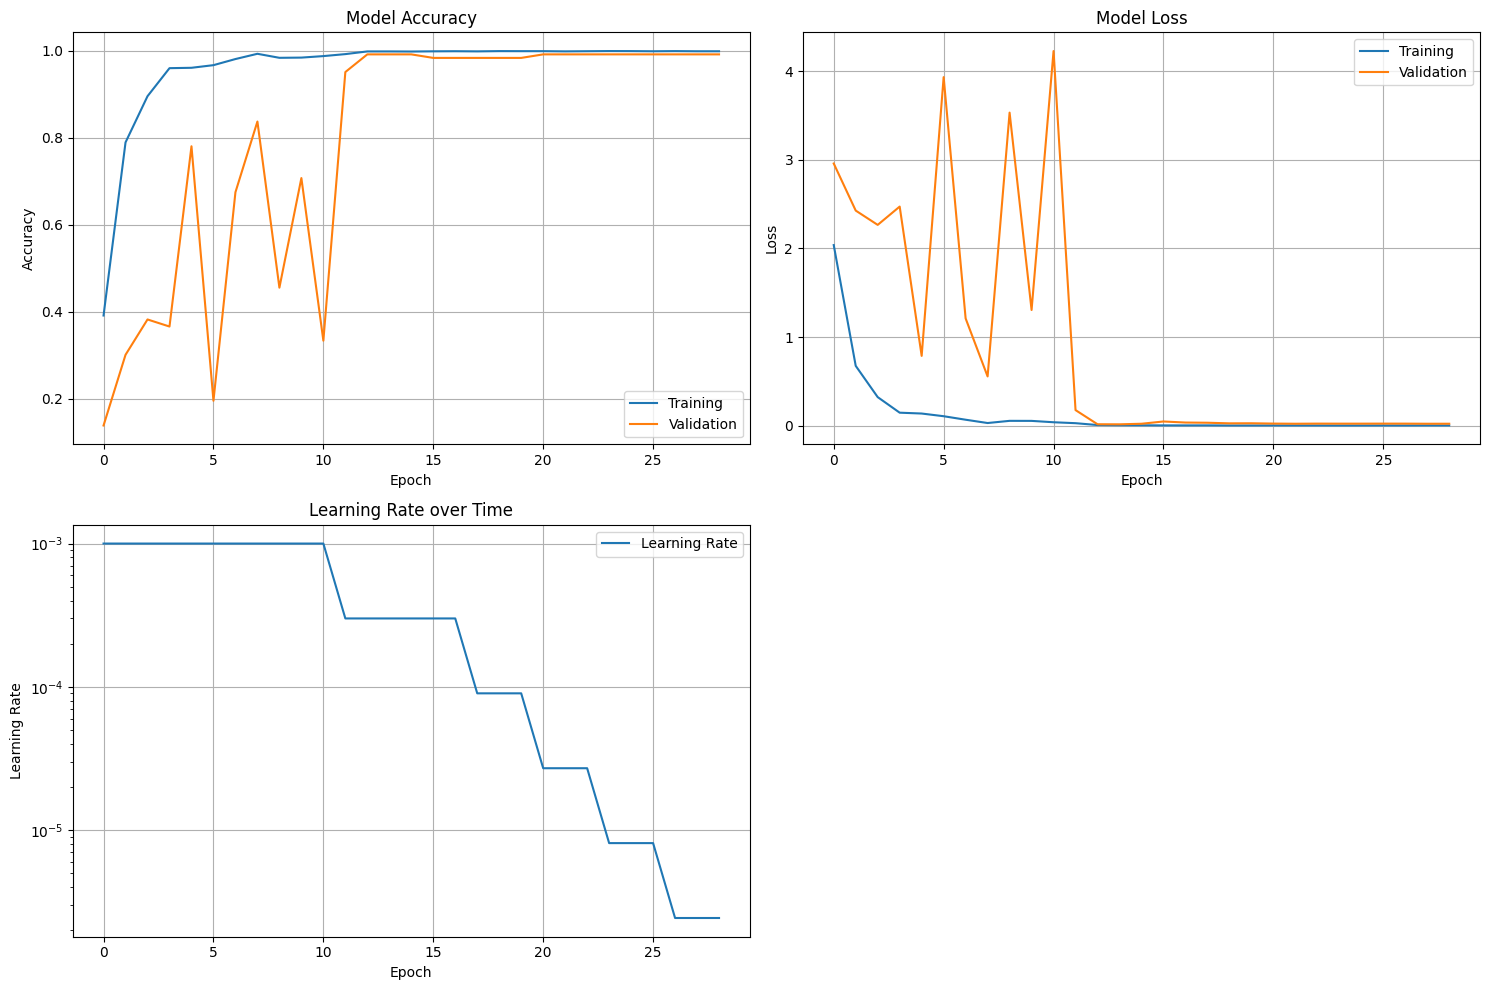


Final Performance Metrics:
Training Accuracy: 0.9990
Validation Accuracy: 0.9919
Training Loss: 0.0026
Validation Loss: 0.0221


In [12]:
def plot_training_history_from_logs():
    """Plot training history from saved logs"""
    try:
        # 从npy文件加载训练历史
        history = np.load('I:/Ece496/augmented_data/history/attention_history.npy', allow_pickle=True).item()
        
        plt.figure(figsize=(15, 10))
        
        # 1. Accuracy Plot
        plt.subplot(2, 2, 1)
        plt.plot(history['accuracy'], label='Training')
        plt.plot(history['val_accuracy'], label='Validation')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # 2. Loss Plot
        plt.subplot(2, 2, 2)
        plt.plot(history['loss'], label='Training')
        plt.plot(history['val_loss'], label='Validation')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # 3. Learning Rate Plot
        plt.subplot(2, 2, 3)
        if 'lr' in history:
            plt.plot(history['lr'], label='Learning Rate')
            plt.title('Learning Rate over Time')
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.legend()
            plt.grid(True)
            plt.yscale('log')

        plt.tight_layout()
        plt.savefig('I:/Ece496/logs/training_history.png')
        plt.show()
        
        # 打印最终性能指标
        print("\nFinal Performance Metrics:")
        print(f"Training Accuracy: {history['accuracy'][-1]:.4f}")
        print(f"Validation Accuracy: {history['val_accuracy'][-1]:.4f}")
        print(f"Training Loss: {history['loss'][-1]:.4f}")
        print(f"Validation Loss: {history['val_loss'][-1]:.4f}")
        
    except Exception as e:
        print(f"Error loading or plotting history: {str(e)}")

# 调用函数绘制图表
plot_training_history_from_logs()

 TEST

In [20]:
# 设置临时文件目录到I盘
temp_dir = "I:/Ece496/temp"
os.makedirs(temp_dir, exist_ok=True)
tempfile.tempdir = temp_dir
os.environ['TMPDIR'] = temp_dir

# 清理临时文件函数
def cleanup_temp():
    try:
        if os.path.exists(temp_dir):
            shutil.rmtree(temp_dir)
            os.makedirs(temp_dir)
            print(f"Temporary directory cleared: {temp_dir}")
    except Exception as e:
        print(f"Error clearing temporary directory: {str(e)}")
    gc.collect()

# 在代码开始前清理临时目录
cleanup_temp()

# ... 原始代码保持不变 ...
gc.collect()
# 1. 首先定义TestDataGenerator
class TestDataGenerator(Sequence):
    """使用内存映射的测试数据生成器"""
    def __init__(self, batch_size=8):
        # 使用内存映射方式加载数据
        self.X = np.load(os.path.join(test_data_dir, "X_test.npy"), mmap_mode='r')
        self.y = np.load(os.path.join(test_data_dir, "y_test.npy"), mmap_mode='r')
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.X))
        
        self.logger = logging.getLogger(__name__)
        self.logger.info(f"Test data generator initialization complete:")
        self.logger.info(f"- Total sample size: {len(self.X)}")
        self.logger.info(f"- batch size: {batch_size}")
        self.logger.info(f"- Number of batches per round: {len(self)}")
    
    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))
    
    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.X))
        batch_indexes = self.indexes[start_idx:end_idx]
        
        # 复制一小部分数据到内存
        batch_x = np.array(self.X[batch_indexes], dtype=np.float32)
        batch_y = np.array(self.y[batch_indexes])
        
        return batch_x, batch_y

# 2. 定义预测函数
def predict_with_mmap_generator(model, batch_size=8):
    """使用内存映射生成器进行预测"""
    try:
        test_generator = TestDataGenerator(batch_size=batch_size)
        predictions = []
        
        for i in tqdm(range(len(test_generator)), desc="Projected progress"):
            batch_x, _ = test_generator[i]
            batch_predictions = model.predict(batch_x, verbose=0)
            predictions.append(batch_predictions)
            gc.collect()  # 及时清理内存
        
        return np.concatenate(predictions, axis=0)
        
    except Exception as e:
        logger.error(f"Errors in the forecasting process: {str(e)}")
        raise

# 3. 定义模型加载函数
def get_model(model_path='I:/Ece496/Code/best_model_attention.h5'):
    """智能加载或创建模型"""
    try:
        print("try load saved model...")
        model = load_model(model_path)
        print("successfuly loaded model！")
    except Exception as e:
        print(f"loading failed ({str(e)})，creating new model...")
        model_builder = ModelBuilder()
        model = model_builder.create_attention_residual_model(
            input_shape=(105, 1584), 
            num_classes=25
        )
        # 尝试加载权重
        try:
            model.load_weights(model_path)
            print("successfuly loaded wight！")
        except Exception as e:
            print(f"warning: unable to load weight ({str(e)})")
    
    return model

# 4. 主执行流程
try:
    # 设置数据目录
    test_data_dir = "I:/Ece496/augmented_data"
    
    # 获取模型
    attention_model = get_model()
    
    print("predicting...")
    test_predictions = predict_with_mmap_generator(attention_model, batch_size=2)
    
    # 加载测试标签用于显示结果（使用内存映射）
    y_test = np.load(os.path.join(test_data_dir, "y_test.npy"), mmap_mode='r')
    
    print("\nComparison of predicted results:")
    for i in range(15):
        true_label = np.argmax(y_test[i])
        pred = np.argmax(test_predictions[i])
        confidence = test_predictions[i][pred]
        
        print(f"\nsample {i}:")
        print(f"true label: class {true_label} ({words[true_label]})")
        print(f"predicted label: class {pred} ({words[pred]}), confidence: {confidence:.4f}")
        
        print("\nTop 3 most likely predictions:")
        top3 = np.argsort(test_predictions[i])[-3:][::-1]
        for idx in top3:
            print(f"{words[idx]}: {test_predictions[i][idx]:.4f}")
        print("-" * 50)

    # 计算整体准确率
    accuracy = np.mean(np.argmax(test_predictions, axis=1) == np.argmax(y_test, axis=1))
    print(f"\nOverall Test Set Accuracy: {accuracy:.4f}")

except Exception as e:
    print(f"Errors in the forecasting process: {str(e)}")

finally:
    gc.collect()
    cleanup_temp()  # 清理临时目录

Temporary directory cleared: I:/Ece496/temp
try load saved model...


INFO:__main__:Test data generator initialization complete:
INFO:__main__:- Total sample size: 332
INFO:__main__:- batch size: 2
INFO:__main__:- Number of batches per round: 166


successfuly loaded model！
predicting...


Projected progress: 100%|██████████| 166/166 [00:38<00:00,  4.37it/s]



预测结果对比:

sample 0:
true label: class 18 (Go To)
predicted label: class 18 (Go To), confidence: 1.0000

Top 3 most likely predictions:
Go To: 1.0000
Help: 0.0000
Sign: 0.0000
--------------------------------------------------

sample 1:
true label: class 3 (father)
predicted label: class 3 (father), confidence: 1.0000

Top 3 most likely predictions:
father: 1.0000
I or me: 0.0000
Help: 0.0000
--------------------------------------------------

sample 2:
true label: class 14 (Again or Repeat)
predicted label: class 14 (Again or Repeat), confidence: 1.0000

Top 3 most likely predictions:
Again or Repeat: 1.0000
Like: 0.0000
Learn: 0.0000
--------------------------------------------------

sample 3:
true label: class 4 (mother)
predicted label: class 4 (mother), confidence: 1.0000

Top 3 most likely predictions:
mother: 1.0000
Yes: 0.0000
see u later: 0.0000
--------------------------------------------------

sample 4:
true label: class 12 (Dog)
predicted label: class 12 (Dog), confidence

显示keypoint test

In [16]:
global_model = None

@tf.function(
    reduce_retracing=True,
    input_signature=[
        tf.TensorSpec(shape=[1, 105, 1584], dtype=tf.float32)
    ]
)
def predict_sign(sequence):
    """Optimized prediction function"""
    global global_model
    return global_model(sequence, training=False)

def test_video(video_path=None, model=None, window_size=105):
    """Test video file and display prediction results"""
    try:
        # Set global model
        global global_model
        global_model = model
        
        # Check video file
        if video_path is None:
            video_dir = "I:/Ece496/test"
            video_files = []
            for ext in ['.mp4', '.avi', '.mov']:
                video_files.extend(glob(os.path.join(video_dir, f"*{ext}")))
            
            if not video_files:
                raise Exception(f"No video files found in directory {video_dir}")
            
            video_path = video_files[0]
        
        print(f"Using video file: {video_path}")
        
        if not os.path.exists(video_path):
            raise Exception(f"Video file does not exist: {video_path}")
        
        # Initialize MediaPipe
        mp_holistic = mp.solutions.holistic
        mp_drawing = mp.solutions.drawing_utils
        
        # Initialize sequence and counters
        sequence = np.zeros((1, window_size, 1584), dtype=np.float32)
        frame_count = 0
        keypoints_detected = 0
        predictions_made = 0
        predictions_queue = []
        last_prediction = None
        
        # Open video file
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise Exception(f"Cannot open video file: {video_path}")
            
        print("Initialization complete, starting video processing...")
        
        with mp_holistic.Holistic(min_detection_confidence=0.3, min_tracking_confidence=0.3) as holistic:
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                
                frame_count += 1
                
                # Process frame
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = holistic.process(frame_rgb)
                
                # Debugging information
                if frame_count % 30 == 0:
                    print(f"\nProcessed {frame_count} frames")
                    print(f"Keypoint detections: {keypoints_detected}")
                    print(f"Predictions made: {predictions_made}")
                    if results.face_landmarks:
                        print("Face landmarks detected")
                    if results.pose_landmarks:
                        print("Pose landmarks detected")
                    if results.left_hand_landmarks:
                        print("Left hand landmarks detected")
                    if results.right_hand_landmarks:
                        print("Right hand landmarks detected")
                
                if results.face_landmarks:
                    keypoints_detected += 1
                    
                    # Create CustomResults object
                    custom_results = CustomResults(
                        face_landmarks=create_filtered_face_landmarks(
                            results.face_landmarks.landmark, selected_indices),
                        pose_landmarks=results.pose_landmarks,
                        left_hand_landmarks=results.left_hand_landmarks,
                        right_hand_landmarks=results.right_hand_landmarks
                    )
                    
                    # Extract keypoints
                    keypoints = extract_keypoints(custom_results)
                    
                    # Update sequence
                    sequence[0] = np.roll(sequence[0], -1, axis=0)
                    sequence[0, -1] = keypoints
                    
                    # Make prediction when enough frames are collected
                    if frame_count >= window_size:
                        predictions_made += 1
                        
                        # Use optimized prediction function
                        prediction = predict_sign(tf.convert_to_tensor(sequence))[0].numpy()
                        predicted_class = np.argmax(prediction)
                        confidence = prediction[predicted_class]
                        
                        # Print current prediction
                        print(f"\nCurrent frame prediction: {words[predicted_class]} (Confidence: {confidence:.2f})")
                        
                        # Print top 3 predictions
                        top3_indices = np.argsort(prediction)[-3:][::-1]
                        print("Top 3 Predictions:")
                        for idx in top3_indices:
                            print(f"  {words[idx]}: {prediction[idx]:.2f}")
                        
                        # Add to predictions queue
                        predictions_queue.append((predicted_class, confidence))
                        if len(predictions_queue) > 5:
                            predictions_queue.pop(0)
                        
                        # Obtain stable prediction
                        if len(predictions_queue) >= 3:
                            recent_predictions = [p[0] for p in predictions_queue[-3:]]
                            most_common = max(set(recent_predictions), key=recent_predictions.count)
                            avg_confidence = np.mean([p[1] for p in predictions_queue[-3:] if p[0] == most_common])
                            
                            if recent_predictions.count(most_common) >= 2 and avg_confidence > 0.5:
                                if last_prediction != most_common:
                                    print(f"\n>>> Stable prediction: {words[most_common]} (Confidence: {avg_confidence:.2f})")
                                    last_prediction = most_common
                
                # Draw landmarks
                if results.face_landmarks:
                    draw_landmarks(frame, custom_results)
                
                # Display frame
                cv2.imshow('Sign Language Detection', frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
        
        print("\nProcessing stats:")
        print(f"Total frames: {frame_count}")
        print(f"Frames with detected keypoints: {keypoints_detected}")
        print(f"Predictions made: {predictions_made}")
        print("Video processing completed!")
        
    except Exception as e:
        print(f"Video processing error: {str(e)}")
        traceback.print_exc()
    finally:
        if 'cap' in locals():
            cap.release()
        cv2.destroyAllWindows()

try:
    # Set temporary file directory
    temp_dir = "I:/Ece496/temp"
    os.makedirs(temp_dir, exist_ok=True)
    tempfile.tempdir = temp_dir
    
    # Load model
    print("Loading model...")
    model = load_model("I:/Ece496/Code/best_model_attention.h5")
    print("Model loaded successfully!")
    
    # Get all video files in the test directory
    test_dir = "I:/Ece496/test"
    video_files = []
    for ext in ['.mp4', '.avi', '.mov']:
        video_files.extend(glob(os.path.join(test_dir, f"*{ext}")))
    
    if not video_files:
        raise Exception(f"No video files found in {test_dir} directory")
    
    print(f"Found {len(video_files)} video files")
    
    # Test each video file
    for i, video_path in enumerate(video_files, 1):
        print(f"\n[{i}/{len(video_files)}] Testing video: {os.path.basename(video_path)}")
        print("-" * 50)
        try:
            test_video(video_path=video_path, model=model)
        except Exception as e:
            print(f"Error processing video {os.path.basename(video_path)}: {str(e)}")
            continue
        print("-" * 50)
    
    print("\nAll videos processed!")
    
except Exception as e:
    print(f"Testing process error: {str(e)}")
    traceback.print_exc()
finally:
    gc.collect()
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)


Loading model...
Model loaded successfully!
Found 1 video files

[1/1] Testing video: please_1_test.mp4
--------------------------------------------------
Using video file: I:/Ece496/test\please_1_test.mp4
Initialization complete, starting video processing...

Processed 30 frames
Keypoint detections: 29
Predictions made: 0
Face landmarks detected
Pose landmarks detected

Processed 60 frames
Keypoint detections: 59
Predictions made: 0
Face landmarks detected
Pose landmarks detected
Right hand landmarks detected

Processed 90 frames
Keypoint detections: 89
Predictions made: 0
Face landmarks detected
Pose landmarks detected
Right hand landmarks detected

Current frame prediction: Please (Confidence: 0.95)
Top 3 Predictions:
  Please: 0.95
  Like: 0.03
  Yes: 0.01

Processing stats:
Total frames: 105
Frames with detected keypoints: 105
Predictions made: 1
Video processing completed!
--------------------------------------------------

All videos processed!


简化test

In [13]:
cleanup_all()
def test_video_fast(video_path=None, model=None, window_size=105):
    """快速视频测试函数 - 不显示视频和关键点"""
    try:
        global global_model
        global_model = model
        
        # 初始化
        sequence = np.zeros((1, window_size, 1584), dtype=np.float32)
        frame_count = 0
        keypoints_detected = 0
        predictions_made = 0
        predictions_queue = []
        last_prediction = None
        
        # 打开视频文件
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise Exception(f"无法打开视频文件: {video_path}")
            
        print("开始处理视频...")
        
        # 使用与原版相同的参数配置
        with mp_holistic.Holistic(
            min_detection_confidence=0.3, 
            min_tracking_confidence=0.3
        ) as holistic:
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                
                frame_count += 1
                
                # 处理帧
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = holistic.process(frame_rgb)
                del frame_rgb
                
                if results.face_landmarks:
                    keypoints_detected += 1
                    
                    custom_results = CustomResults(
                        face_landmarks=create_filtered_face_landmarks(
                            results.face_landmarks.landmark, selected_indices),
                        pose_landmarks=results.pose_landmarks,
                        left_hand_landmarks=results.left_hand_landmarks,
                        right_hand_landmarks=results.right_hand_landmarks
                    )
                    
                    keypoints = extract_keypoints(custom_results)
                    sequence[0] = np.roll(sequence[0], -1, axis=0)
                    sequence[0, -1] = keypoints
                    
                    if frame_count >= window_size:
                        predictions_made += 1
                        prediction = predict_sign(tf.convert_to_tensor(sequence))[0].numpy()
                        predicted_class = np.argmax(prediction)
                        confidence = prediction[predicted_class]
                        
                        if confidence > 0.8:
                            print(f"检测到: {words[predicted_class]} (置信度: {confidence:.2f})")
                        
                        predictions_queue.append((predicted_class, confidence))
                        if len(predictions_queue) > 5:
                            predictions_queue.pop(0)
                        
                        if len(predictions_queue) >= 3:
                            recent_predictions = [p[0] for p in predictions_queue[-3:]]
                            most_common = max(set(recent_predictions), key=recent_predictions.count)
                            avg_confidence = np.mean([p[1] for p in predictions_queue[-3:] if p[0] == most_common])
                            
                            if recent_predictions.count(most_common) >= 2 and avg_confidence > 0.5:
                                if last_prediction != most_common:
                                    print(f">>> 稳定预测: {words[most_common]} (置信度: {avg_confidence:.2f})")
                                    last_prediction = most_common
        
        # 最终结果
        if predictions_queue:
            all_predictions = [p[0] for p in predictions_queue if p[1] > 0.5]
            if all_predictions:
                final_prediction = max(set(all_predictions), key=all_predictions.count)
                final_confidence = np.mean([p[1] for p in predictions_queue if p[0] == final_prediction])
                print(f"\n最终结果: {words[final_prediction]} (平均置信度: {final_confidence:.2f})")
        
        print(f"\n总帧数: {frame_count}")
        print(f"有效帧数: {keypoints_detected}")
        print(f"预测次数: {predictions_made}")
        
    except Exception as e:
        print(f"处理出错: {str(e)}")
    finally:
        if 'cap' in locals():
            cap.release()
try:
    print("加载模型...")
    model = load_model("I:/Ece496/Code/best_model_attention.h5")
    print("模型加载成功！")
    
    test_dir = "I:/Ece496/test"
    video_files = []
    for ext in ['.mp4', '.avi', '.mov']:
        video_files.extend(glob(os.path.join(test_dir, f"*{ext}")))
    
    print(f"找到 {len(video_files)} 个视频文件")
    
    for i, video_path in enumerate(video_files, 1):
        print(f"\n[{i}/{len(video_files)}] 测试视频: {os.path.basename(video_path)}")
        print("-" * 50)
        test_video_fast(video_path=video_path, model=model)
        print("-" * 50)
    
    print("\n所有视频处理完成！")
    
except Exception as e:
    print(f"错误: {str(e)}")
finally:
    gc.collect()

加载模型...
模型加载成功！
找到 2 个视频文件

[1/2] 测试视频: Eat Food_5_Angela.mp4
--------------------------------------------------
开始处理视频...
处理出错: name 'predict_sign' is not defined
--------------------------------------------------

[2/2] 测试视频: Eat_Food_16_Amelie.mp4
--------------------------------------------------
开始处理视频...
处理出错: name 'predict_sign' is not defined
--------------------------------------------------

所有视频处理完成！


实时test

In [7]:
class PredictionSmoother:
    def __init__(self, window_size=10, confidence_threshold=0.75):
        self.window_size = window_size
        self.confidence_threshold = confidence_threshold
        self.predictions_history = []
        self.last_stable_prediction = None
        
    def update(self, new_prediction):
        # 添加新预测到历史记录
        self.predictions_history.append(new_prediction)
        
        # 保持窗口大小固定
        if len(self.predictions_history) > self.window_size:
            self.predictions_history.pop(0)
            
        # 计算平滑预测
        if len(self.predictions_history) >= 3:  # 至少需要几个预测才开始输出
            # 使用指数加权平均
            weights = np.exp(np.linspace(-1, 0, len(self.predictions_history)))
            weights /= weights.sum()  # 归一化权重
            
            # 计算加权平均
            smooth_prediction = np.average(
                self.predictions_history, 
                weights=weights,
                axis=0
            )
            
            # 如果最高概率超过阈值，更新稳定预测
            max_prob = np.max(smooth_prediction)
            if max_prob > self.confidence_threshold:
                self.last_stable_prediction = smooth_prediction
                
            return smooth_prediction, self.last_stable_prediction
            
        return None, None

    def reset(self):
        """重置预测器状态"""
        self.predictions_history = []
        self.last_stable_prediction = None

In [11]:
import numpy as np
import cv2
import mediapipe as mp

# 初始化
model_with_velocity.load_weights(r"I:\Ece496\custom_data\weight1_with_velocity.h5")
mp_holistic = mp.solutions.holistic

# 设置滑动窗口
window_size = 105
num_keypoints = 1584  # 每帧关键点数量
sequence = np.zeros((window_size, num_keypoints), dtype=float)
required_non_zero_ratio = 0.9  # 设置至少90%的帧要非零
frame_count = 0  # 初始化帧计数器

# 初始化预测平滑器
smoother = PredictionSmoother(window_size=10, confidence_threshold=0.75)

# 打开摄像头
cap = cv2.VideoCapture(0)
predicted_labels = []
last_predictions = None

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)

        custom_results = CustomResults(
            face_landmarks=create_filtered_face_landmarks(results.face_landmarks.landmark, selected_indices) if results.face_landmarks else None,
            pose_landmarks=results.pose_landmarks,
            left_hand_landmarks=results.left_hand_landmarks,
            right_hand_landmarks=results.right_hand_landmarks
        )

        keypoints = extract_keypoints(custom_results)

        if keypoints is not None:
            # 更新关键点序列
            sequence[:-1] = sequence[1:]
            sequence[-1] = keypoints
            frame_count += 1

            # 跳过前105帧
            if frame_count < window_size:
                print(f"Skipping frame {frame_count}")
                continue

            # 检查滑动窗口中非零帧的比例
            non_zero_frames = np.count_nonzero(np.any(sequence != 0, axis=1))
            if non_zero_frames / window_size >= required_non_zero_ratio:
                # 获取原始预测
                raw_prediction = model_with_velocity.predict(
                    np.expand_dims(sequence, axis=0), 
                    verbose=0
                )[0]
                
                # 使用平滑器处理预测结果
                smooth_pred, stable_pred = smoother.update(raw_prediction)
                
                if smooth_pred is not None:
                    # 使用平滑后的预测更新显示
                    last_predictions = smooth_pred
                    
                    # 如果有稳定预测，打印结果
                    if stable_pred is not None:
                        predicted_class = np.argmax(stable_pred)
                        confidence = stable_pred[predicted_class]
                        print(f"Stable Prediction: {words[predicted_class]} ({confidence:.2f})")

        # 在帧上显示预测概率
        if last_predictions is not None:
            for idx, prob in enumerate(last_predictions):
                # 添加颜色编码：高置信度显示绿色，低置信度显示红色
                if prob > 0.75:
                    color = (0, 255, 0)  # 绿色
                elif prob > 0.5:
                    color = (0, 255, 255)  # 黄色
                else:
                    color = (0, 0, 255)  # 红色
                    
                text = f"{words[idx]}: {prob:.2f}"
                cv2.putText(frame, text, (10, 30 + idx * 30), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)

        cv2.imshow('MediaPipe Holistic', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


Skipping frame 1
Skipping frame 2
Skipping frame 3
Skipping frame 4
Skipping frame 5
Skipping frame 6
Skipping frame 7
Skipping frame 8
Skipping frame 9
Skipping frame 10
Skipping frame 11
Skipping frame 12
Skipping frame 13
Skipping frame 14
Skipping frame 15
Skipping frame 16
Skipping frame 17
Skipping frame 18
Skipping frame 19
Skipping frame 20
Skipping frame 21
Skipping frame 22
Skipping frame 23
Skipping frame 24
Skipping frame 25
Skipping frame 26
Skipping frame 27
Skipping frame 28
Skipping frame 29
Skipping frame 30
Skipping frame 31
Skipping frame 32
Skipping frame 33
Skipping frame 34
Skipping frame 35
Skipping frame 36
Skipping frame 37
Skipping frame 38
Skipping frame 39
Skipping frame 40
Skipping frame 41
Skipping frame 42
Skipping frame 43
Skipping frame 44
Skipping frame 45
Skipping frame 46
Skipping frame 47
Skipping frame 48
Skipping frame 49
Skipping frame 50
Skipping frame 51
Skipping frame 52
Skipping frame 53
Skipping frame 54
Skipping frame 55
Skipping frame 56
S

带有holding,waiting,detecting的实时test

In [8]:
import numpy as np
import cv2
import mediapipe as mp
import time

# MediaPipe初始化
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

class MotionDetector:
    def __init__(self, window_size=10, motion_threshold=0.003):  # 降低阈值到0.003
        self.window_size = window_size
        self.motion_threshold = motion_threshold
        self.frame_buffer = []
        
    def calculate_motion(self, keypoints):
        """
        更新motion计算方法，使其更敏感
        """
        # 提取手部和面部关键点
        face_points = keypoints[:90*3]  
        left_hand = keypoints[411:411+63]
        right_hand = keypoints[474:474+63]
        
        # 给予手部更高的权重
        weighted_points = np.concatenate([
            face_points * 0.5,    # 降低面部权重
            left_hand * 2.0,      # 增加手部权重
            right_hand * 2.0
        ])
        
        if not self.frame_buffer:
            motion = 0
        else:
            prev_frame = self.frame_buffer[-1]
            diff = weighted_points - prev_frame
            # 使用最大位移而不是平均位移
            motion = np.max(np.abs(diff))
        
        self.frame_buffer.append(weighted_points)
        if len(self.frame_buffer) > self.window_size:
            self.frame_buffer.pop(0)
            
        return motion

class GestureRecognizer:
    def __init__(self, 
                 model,                   # 添加模型参数
                 motion_threshold=0.003,  # 降低阈值
                 hold_time=0.3,          # 减少保持时间
                 smooth_window=5,
                 transition_delay=0.1):   # 减少延迟
        # 确保保存模型到实例变量
        self.model = model               # 在这里保存模型！
        
        # 其他初始化
        self.motion_detector = MotionDetector(motion_threshold=motion_threshold)
        self.predictor = PredictionSmoother(window_size=smooth_window)
        self.state = 'WAITING'
        self.last_stable_gesture = None
        self.hold_start_time = None
        self.hold_threshold = hold_time
        self.transition_delay = transition_delay
        self.last_state_change = time.time()
        self.consecutive_low_motion = 0
        self.consecutive_high_motion = 0
        
        self.debug_info = {
            'motion_level': 0,
            'state': self.state,
            'time_in_state': 0,
            'consecutive_low': 0,
            'consecutive_high': 0
        }
        
    def update(self, sequence):
        current_time = time.time()
        motion_level = self.motion_detector.calculate_motion(sequence[-1])
        self.debug_info['motion_level'] = motion_level
        
        # 更新连续计数，降低要求
        if motion_level > self.motion_detector.motion_threshold:
            self.consecutive_high_motion += 1
            self.consecutive_low_motion = max(0, self.consecutive_low_motion - 2)  # 快速减少low count
        else:
            self.consecutive_low_motion += 1
            self.consecutive_high_motion = max(0, self.consecutive_high_motion - 1)  # 缓慢减少high count
            
        self.debug_info['consecutive_low'] = self.consecutive_low_motion
        self.debug_info['consecutive_high'] = self.consecutive_high_motion

        if self.state == 'WAITING':
            # 降低进入DETECTING的要求
            if self.consecutive_high_motion >= 2:  # 只需要2帧高运动
                self.state = 'DETECTING'
                self.last_state_change = current_time
                self.predictor.reset()
                
        elif self.state == 'DETECTING':
            raw_prediction = self.model.predict(
                np.expand_dims(sequence, axis=0), verbose=0)[0]
            
            smooth_pred, stable_pred = self.predictor.update(raw_prediction)
            
            # 降低进入HOLDING的要求
            if self.consecutive_low_motion >= 3:  # 只需要3帧低运动
                if stable_pred is not None:
                    self.last_stable_gesture = stable_pred
                    self.state = 'HOLDING'
                    self.hold_start_time = current_time
                    self.last_state_change = current_time
                    
        elif self.state == 'HOLDING':
            if self.consecutive_high_motion >= 2:
                self.state = 'DETECTING'
                self.last_state_change = current_time
                self.predictor.reset()
            elif current_time - self.hold_start_time > self.hold_threshold:
                self.state = 'WAITING'
                self.last_state_change = current_time
        
        self.debug_info['state'] = self.state
        self.debug_info['time_in_state'] = current_time - self.last_state_change
        
        return self.last_stable_gesture

def draw_debug_info(frame, recognizer):
    info = recognizer.debug_info
    
    # 显示动作量和阈值
    motion_bar_length = min(int(info['motion_level'] * 1000), 200)
    threshold_bar_length = int(recognizer.motion_detector.motion_threshold * 1000)
    
    # 动作量条
    cv2.rectangle(frame, (10, 400), (10 + motion_bar_length, 420), 
                 (0, 255, 0), -1)
    # 阈值线
    cv2.line(frame, (10 + threshold_bar_length, 395), 
             (10 + threshold_bar_length, 425), (0, 0, 255), 2)
    
    cv2.putText(frame, f"Motion: {info['motion_level']:.3f}", 
                (220, 415), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    
    # 显示连续计数
    cv2.putText(frame, f"Consecutive low: {info['consecutive_low']}", 
                (10, 440), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    cv2.putText(frame, f"Consecutive high: {info['consecutive_high']}", 
                (10, 460), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    
    # 显示状态
    state_colors = {
        'WAITING': (255, 255, 255),
        'DETECTING': (0, 255, 255),
        'HOLDING': (0, 255, 0)
    }
    cv2.putText(frame, f"State: {info['state']}", 
                (10, 480), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 
                state_colors[info['state']], 2)
    
    cv2.putText(frame, f"Time in state: {info['time_in_state']:.1f}s",
                (10, 500), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
def main():
    # 初始化参数
    window_size = 105
    num_keypoints = 1584
    sequence = np.zeros((window_size, num_keypoints), dtype=float)
    frame_count = 0
    last_predictions = None

    # 加载模型
    print("Loading model...")
    model = load_model("I:/Ece496/Code/best_model_attention.h5")
    print("Model loaded successfully!")
    
    # 初始化识别器
    recognizer = GestureRecognizer(
        model=model, 
        motion_threshold=0.05,
        hold_time=1.0,
        smooth_window=10,
        transition_delay=0.5
    )

    # 打开摄像头
    cap = cv2.VideoCapture(0)
    
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = holistic.process(frame_rgb)

            custom_results = CustomResults(
                face_landmarks=create_filtered_face_landmarks(results.face_landmarks.landmark, selected_indices) 
                    if results.face_landmarks else None,
                pose_landmarks=results.pose_landmarks,
                left_hand_landmarks=results.left_hand_landmarks,
                right_hand_landmarks=results.right_hand_landmarks
            )

            keypoints = extract_keypoints(custom_results)

            if keypoints is not None:
                sequence[:-1] = sequence[1:]
                sequence[-1] = keypoints
                frame_count += 1

                if frame_count >= window_size:
                    prediction = recognizer.update(sequence)
                    if prediction is not None:
                        last_predictions = prediction

            if last_predictions is not None:
                for idx, prob in enumerate(last_predictions):
                    text = f"{words[idx]}: {prob:.2f}"
                    color = (0, 255, 0) if prob > 0.75 else (0, 255, 255)
                    cv2.putText(frame, text, (10, 30 + idx * 30), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            draw_debug_info(frame, recognizer)
            cv2.imshow('MediaPipe Holistic', frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == '__main__':
    main()

Loading model...
Model loaded successfully!
